# Importing the Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2 as cv

In [ ]:
import tensorflow as tf
import sklearn.model_selection
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Lambda
from tensorflow.keras.models import Model
# from tensorflow.keras import backend as K

# Importing the Dataset

In [ ]:
train = pd.read_csv("") # Enter train csv file
test = pd.read_csv("") # Enter test csv file
train_dir = "" # Enter train directory containing employees' valid and forged signature folders
test_dir = "" # Enter test directory containing employees' valid and forged signature folders

In [ ]:
def preprocess(img):
    img = cv.resize(img, (128, 128, ))
    img = cv.Canny(img, 20, 200)
    img = img / 255.
    img = np.expand_dims(img, axis = -1)
    return img

def show_image(image):
    plt.figure()
    plt.imshow(image, cmap = "grey")
    plt.grid(False)
    plt.show()

In [ ]:
def create_pairs_on_set(dataset, dir):
    os.chdir(dir)
    pairs = []
    labels = []

    for i in range(dataset.shape[0]):
        if i % 1000 == 0:
            print(i)
        img1 = cv.imread(dataset.iloc[i, 0])
        img1 = preprocess(img1)
        img2 = cv.imread(dataset.iloc[i, 1])
        img2 = preprocess(img2)
        pairs += [[img1, img2]]
        labels += [dataset.iloc[i, 2]]

    tr_pairs = np.array(pairs)
    tr_y = np.array(labels)
    tr_y = tr_y.astype('float32')
    return tr_pairs, tr_y

In [ ]:
train_set, val_set = sklearn.model_selection.train_test_split(train, test_size = 0.2)
tr_pairs, tr_y = create_pairs_on_set(train_set, train_dir)
vl_pairs, vl_y = create_pairs_on_set(val_set, train_dir)
ts_pairs, ts_y = create_pairs_on_set(test, test_dir)

In [ ]:
this_pair = 100

show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

print(ts_y[this_pair])

# Creating  and Training the Model

In [ ]:
def create_siamese_model():
    input = Input(shape = (128, 128, 1), name = "base_input")
    x = Conv2D(16, (3, 3), activation = 'relu')(input)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(32, (3, 3), activation = 'relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, (3, 3), activation = 'relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, (3, 3), activation = 'relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(512, activation = 'relu')(x)
    x = Dense(128, activation='relu')(x)

    return Model(inputs = input, outputs = x)

In [ ]:
base_network = create_siamese_model()

In [ ]:
input_a = Input(shape = (128, 128, 1), name = "image1")
vect_output_a = base_network(input_a)

input_b = Input(shape = (128, 128, 1), name = "image2")
vect_output_b = base_network(input_b)

manhattan_distance_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
manhattan_distance = manhattan_distance_layer([vect_output_a, vect_output_b])

output = Dense(1, activation = 'sigmoid')(manhattan_distance)

model = Model([input_a, input_b], output)

In [ ]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [ ]:
history = model.fit([tr_pairs[:,0][:5000], tr_pairs[:,1][:5000]], tr_y[:5000], epochs = 10, batch_size = 128,
                    validation_data = ([vl_pairs[:,0][:1000], vl_pairs[:,1][:1000]], vl_y[:1000]))

Epoch 1/10
40/40 [==============================] - 50s 1s/step - loss: 0.6533 - accuracy: 0.6148 - val_loss: 0.6551 - val_accuracy: 0.5830
Epoch 2/10
40/40 [==============================] - 55s 1s/step - loss: 0.6093 - accuracy: 0.6746 - val_loss: 0.6293 - val_accuracy: 0.6190
Epoch 3/10
40/40 [==============================] - 48s 1s/step - loss: 0.5903 - accuracy: 0.6932 - val_loss: 0.6042 - val_accuracy: 0.6810
Epoch 4/10
40/40 [==============================] - 46s 1s/step - loss: 0.5590 - accuracy: 0.7104 - val_loss: 0.5619 - val_accuracy: 0.7140
Epoch 5/10
40/40 [==============================] - 45s 1s/step - loss: 0.5092 - accuracy: 0.7466 - val_loss: 0.5039 - val_accuracy: 0.7430
Epoch 6/10
40/40 [==============================] - 45s 1s/step - loss: 0.4404 - accuracy: 0.8004 - val_loss: 0.4540 - val_accuracy: 0.7870
Epoch 7/10
40/40 [==============================] - 45s 1s/step - loss: 0.3739 - accuracy: 0.8302 - val_loss: 0.3764 - val_accuracy: 0.8240
Epoch 8/10
40/40 [==

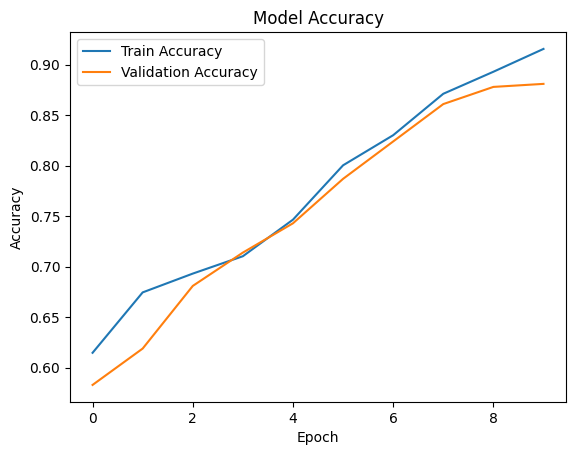

In [ ]:
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# Testing the Model

In [ ]:
model.evaluate([ts_pairs[:,0], ts_pairs[:,1]], ts_y)

180/180 [==============================] - 15s 84ms/step - loss: 0.2702 - accuracy: 0.8904


[0.2702331840991974, 0.8903775811195374]

In [ ]:
y_prob = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
y_pred = (y_prob > 0.5).astype(int)
y_pred = list(np.squeeze(y_pred))
y_test = ts_y

180/180 [==============================] - 15s 84ms/step


In [ ]:
np.sum(y_test == y_pred) * 100 / len(y_pred) # print accuracy

89.03775883069427

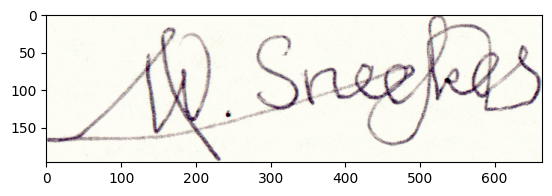

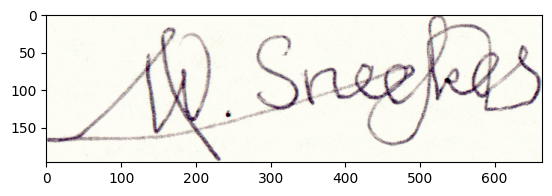

In [ ]:
img1 = cv.imread("") # Enter image 1 path
img2 = cv.imread("") # Enter image 2 path
show_image(img1)
show_image(img2)
img1 = preprocess(img1)
img1 = np.expand_dims(img1, axis = 0)
img2 = preprocess(img2)
img2 = np.expand_dims(img2, axis = 0)

In [ ]:
y_prob_one = model.predict([img1, img2])
y_pred = (y_prob_one > 0.5).astype(int)
print(y_prob_one, y_pred)

1/1 [==============================] - 0s 15ms/step
[[0.46497273]] [[0]]


# Saving the Model

In [ ]:
model.save('my_model.h5') # Enter path for saving model